# Low-visibility events in Flowerday et al 2024 GSL Playa Dust paper/study 

### Task 1: 
* For three urban sites back to 2000, count number of dust events using NWS definition of visibility < 400m
* Set a threshold (e.g., three hours?) that would count as a dust event
* The three urban sites are:
  - Bountiful (EPA AIRS Code: 490110001 before 2003, changed to EPA AIRS Code: 490110004 in 2003; address: 171 West 1370 North, Bountiful, UT)
  - Hawthorne Elementary (EPA AIRS Code: 490353006, address: 1675 South 600 East, Salt Lake City, UT)
  - Weber (EPA AIRS Code: 490353006, address: 425 West 2550 North, Harrisville, UT)

So for MesoWest data:      
* Bountiful (QBV) does not have visibility but is close to UTLGP.
* Hawthorne (QHW) does not have visibility but is close to UTSUG.
* Weber (QHV) does not have visibility but is close to UTFRW.

### Task 2:
* For a number of "filter sites", do time series of visibility data from midnight to midnight local time.
* The stations are in the paper manuscript but also the sites are:
    - H3 – 490353013 (14058 Mirabella Drive, Herriman) - QH3 but nearest vis is UTJUN
    - EQ – 490353015 (240 North 1950 West, Salt Lake City) - nearest vis is UT215
    - MG – 490351001 (2935 S 8560 W, Magna) - nearest is UTMV2
    - He – 490353008 (12885 5600 W, Herriman) - can also use UTJUN
    - O2 – 490570002 (228 32nd St, Ogden) - use KOGD 
 
* Then the dates for each site are in the next table.
* 
| Case | Site                   | Date       |
|------|------------------------|------------|
| 1    | Herriman (H3)          | 04/23/2022 |
| 2    | Herriman (H3)          | 05/31/2022 |
| 3    | Herriman (H3)          | 06/17/2022 |
| 4    | Herriman (H3)          | 06/20/2022 |
| 5    | Utah Tech Center (EQ)  | 06/17/2022 |
| 6    | Utah Tech Center (EQ)  | 06/18/2022 |
| 7    | Utah Tech Center (EQ)  | 06/20/2022 |
| 8    | Utah Tech Center (EQ)  | 09/07/2020 |
| 9    | Utah Tech Center (EQ)  | 09/09/2020 |
| 10   | Herriman (H3)          | 12/20/2017 |
| 11   | Magna (MG)             | 12/20/2017 |
| 12   | Magna (MG)             | 12/21/2017 |
| 13   | Herriman (He)          | 04/14/2015 |
| 14   | Herriman (He)          | 04/15/2015 |
| 15   | Ogden (O2)             | 04/14/2015 |
| 16   | Ogden (O2)             | 04/15/2015 |


### Task 3:
* Ensemble trajectories for each of the dates/locations in the table above 
* We want to show what direction dust came from to see if the paths crosses known dust sources

### Task 4:
* An explanation of methodology (formally, for the paper)

### Task 5:
* A discussion - perhaps more informally from my notes during testing (LaTeX PDF doc)


In [1]:
import datetime
import os
import requests

import matplotlib as M
import matplotlib.pyplot as plt 
import pandas as pd 
import synoptic.services as ss
import numpy as np 
import windrose 


/Users/johnlawson/anaconda3/envs/gsl-dust-env/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
# Defaults for figures

# Change some general default settings to make figures stand out  but professional 
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12

# Font choice preferences in order are helvetica, helvetica neue, arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Helvetica Neue', 'Arial']



In [3]:
def get_stid_timeseries(stid, start_date, end_date, vrbls):
    """
    Get time series data for a given station id (stid) for a given time period
    """
    stid_df = ss.stations_timeseries(stid=stid,start=start_date,end=end_date,
                                        vars=vrbls, verbose=True)
    return stid_df

In [4]:
def create_windrose_plot(df, n_split=3, case_title=None):
    """
    Create a windrose plot for the wind direction and wind speed
    """
    if n_split == 2:
        # Split into first half of data (7pm-7am, "night") and second half (7am-7pm, "day")
        # plot of left and right, respectively
        split_ix = len(df) // 2
    elif n_split == 3:
        # Split into three parts of 8 hours  
        # first third is 7pm to 3am ("night"), second third is 3am to 11am ("morning"), and last third is 11am to 7pm ("afternoon")
        split_ix1 = len(df) // 3
        split_ix2 = 2 * len(df) // 3
    else:
        raise ValueError("n_split must be 2 or 3")
    
    if n_split == 2:
        df1 = df.iloc[:split_ix]
        df2 = df.iloc[split_ix:]
        dfs = [df1, df2]
        period_names = ['Night', 'Day']
    elif n_split == 3:
        df1 = df.iloc[:split_ix1]
        df2 = df.iloc[split_ix1:split_ix2]
        df3 = df.iloc[split_ix2:]
        dfs = [df1, df2, df3]
        period_names = ['Night', 'Morning', 'Afternoon']
    else:
        raise ValueError("n_split must be 2 or 3")

    # Create a figure and axis
    fig, axes = plt.subplots(1, n_split, figsize=(13, 6), subplot_kw={'projection': 'windrose'})
    
    # Set bins to be rounder numbers (integers)
    bins = np.arange(0, 16, 3)
    
    # Plot the windrose for each split
    for i, (df, ax) in enumerate(zip(dfs, axes)):
       
        ax = windrose.WindroseAxes.from_ax(ax)
        ax.bar(df['wind_direction'], df['wind_speed'], normed=True, opening=0.8, edgecolor='white', bins=bins)
        # ax.box(df['wind_direction'], df['wind_speed'], bins=bins)
        # ax.contour(df['wind_direction'], df['wind_speed'], bins=bins, cmap=M.cm.hot, lw=3)

        # Set title for subplot 
        ax.set_title(period_names[i])
            
    axes.flatten()[0].set_legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    if case_title:
        axes.flatten()[1].text(.5, -0.2, case_title, transform=axes.flatten()[1].transAxes, ha='center', va='top')
    
    plt.tight_layout()
    return fig, axes

def plot_case_windroses(case_num, title=None, case_df=None):
    case_row = case_df.loc[case_num]
    wind_stid = stids_vis[case_row['Site']]
    start_date = datetime.datetime(case_row['Date'].year, case_row['Date'].month, case_row['Date'].day, 0, 0, 0
                                   ) - datetime.timedelta(hours=7) # UTC to local
    end_date = datetime.datetime(case_row['Date'].year, case_row['Date'].month, case_row['Date'].day, 23, 59, 59
                                    ) - datetime.timedelta(hours=7) # UTC to local
                                 
    wind_df = get_stid_timeseries(wind_stid, start_date, end_date, vrbls) 
    
    if title is None:
        case_title = ""
    else:
        case_title = f"Case {case_num}: {datetime.datetime.now().strftime('%m/%d/%Y')}"

    fig, axes = create_windrose_plot(wind_df, case_title=case_title)
    return fig, axes

In [5]:
# Task 1 - longer term data 

start_date = datetime.datetime(2004,1,1,0,0,0)
end_date = datetime.datetime(2024,1,1,0,0,0)

# Get site stids for the three sites with MesoWest/Synoptic data 
stids_aq = {'Bountiful': 'QBV', 'Hawthorne': 'QHW', 'Weber': 'QHV'}

# Now list the closest stid to each location that has visibility data
stids_vis = {'Bountiful': 'UTLGP', 'Hawthorne': 'UTSUG', 'Weber': 'UTFRW'}

vrbls = ["visibility",]

stid_dict = {}

for loc, stid in stids_vis.items():    
    data_fpath = f"./data/{stid}.csv"
    
    if os.path.exists(data_fpath):
        _df = pd.read_csv(data_fpath)
        _df.set_index('date_time',inplace=True)
    else:
        _df = get_stid_timeseries(stid, start_date, end_date, vrbls)
        _df.to_csv(data_fpath)
    stid_dict[loc] = _df

# for sake of debugging
# site = "Hawthorne"
site = "Bountiful"

stid = stids_vis[site]
stid_df = stid_dict[site].copy(deep=True)


stid_df

,visibility
date_time,
2013-07-30 17:50:00+00:00,12.40
2013-07-30 18:00:00+00:00,12.39
2013-07-30 18:10:00+00:00,12.39
2013-07-30 18:20:00+00:00,12.39
2013-07-30 18:30:00+00:00,12.39
...,...
2023-12-31 23:10:00+00:00,10.00
2023-12-31 23:30:00+00:00,10.00
2023-12-31 23:40:00+00:00,10.00


In [6]:
# Now let's detect a "dust event" using the NWS definition of visibility < 400m for 3 hours
# We can do this by creating a new column that is True if visibility < 400m
# Visibility is in miles! So 400m = 0.248548 miles
# TODO consider doing for quarter and half mile? 
viz_miles = 0.248548
# viz_miles = 0.5
stid_df['dust_threshold'] = stid_df['visibility'] < viz_miles

# Calculate if a dust event is underway if the threshold is exceeded for 3 hours
# Note the date_time index so the three hours can be computed from this 
# stid_df['dust_event'] = stid_df['dust_threshold'].rolling(window='3h').sum() == 3

# Print the number of dust threshold exceedances and dust events
print(f"Number of dust threshold exceedances: {stid_df['dust_threshold'].sum()}")
# print(f"Number of dust events: {stid_df['dust_event'].sum()}")

stid_df[stid_df["dust_threshold"] == True]


Number of dust threshold exceedances: 1274


,visibility,dust_threshold
date_time,,
2013-10-23 21:10:00+00:00,0.19,True
2013-10-23 21:20:00+00:00,0.02,True
2013-10-23 21:30:00+00:00,0.01,True
2013-10-23 21:40:00+00:00,0.01,True
2013-10-23 21:50:00+00:00,0.02,True
...,...,...
2023-12-18 09:00:00+00:00,0.24,True
2023-12-18 09:10:00+00:00,0.23,True
2023-12-18 09:20:00+00:00,0.24,True


In [7]:
cluster_df = stid_df.copy(deep=True)

# Parameters
max_gap_hours = 3

# Identify clusters of True values
cluster_df['Cluster'] = (cluster_df['dust_threshold'] != cluster_df['dust_threshold'].shift()).cumsum()

# Filter out clusters of True values
true_clusters = cluster_df[cluster_df['dust_threshold']].groupby('Cluster', group_keys=False).apply(lambda x: (x.index[0], x.index[-1])).tolist()

# Merge clusters separated by less than max_gap_hours
merged_clusters = []
current_cluster = true_clusters[0]

for start, end in true_clusters[1:]:
    if (pd.Timestamp(start) - pd.Timestamp(current_cluster[1])) <= pd.Timedelta(hours=max_gap_hours):
        current_cluster = (current_cluster[0], end)
    else:
        merged_clusters.append(current_cluster)
        current_cluster = (start, end)

merged_clusters.append(current_cluster)

# Label each event with a case number and measure their length
events = []
for i, (start, end) in enumerate(merged_clusters, start=1):
    start_ts = pd.Timestamp(start).floor('min')
    end_ts = pd.Timestamp(end).floor('min')
    duration_t = int((end_ts - start_ts).total_seconds() / 60)  # duration in minutes as integer
    events.append({
        'Event': i,
        'Start Date': start_ts,
        'End Date': end_ts,
        'Duration (min)': duration_t,
        
    })

# Create a DataFrame for the events
events_df = pd.DataFrame(events)

# Display the DataFrame with formatted dates
events_df['Start Date'] = events_df['Start Date'].dt.strftime('%Y-%m-%d %H:%M')
events_df['End Date'] = events_df['End Date'].dt.strftime('%Y-%m-%d %H:%M')

# Set case number as index 
events_df.set_index("Event", inplace=True)

events_df

/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_85396/398452849.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  true_clusters = cluster_df[cluster_df['dust_threshold']].groupby('Cluster', group_keys=False).apply(lambda x: (x.index[0], x.index[-1])).tolist()


,Start Date,End Date,Duration (min)
Event,,,
1,2013-10-23 21:10,2013-10-24 17:20,1210
2,2013-11-05 11:50,2013-11-05 12:50,60
3,2013-12-03 09:50,2013-12-03 14:00,250
4,2013-12-03 19:10,2013-12-03 19:10,0
5,2013-12-08 00:40,2013-12-08 01:30,50
...,...,...,...
124,2023-03-13 06:20,2023-03-13 06:30,10
125,2023-04-24 16:20,2023-04-24 16:20,0
126,2023-12-17 13:20,2023-12-17 14:10,50


In [8]:
# Now subset to find only those cases where duration exceeds 180 min 
events_df[events_df["Duration (min)"] > 180]

,Start Date,End Date,Duration (min)
Event,,,
1,2013-10-23 21:10,2013-10-24 17:20,1210
3,2013-12-03 09:50,2013-12-03 14:00,250
7,2013-12-13 06:10,2013-12-13 09:50,220
9,2013-12-16 02:50,2013-12-16 11:20,510
10,2013-12-16 23:10,2013-12-17 15:30,980
11,2013-12-18 03:50,2013-12-18 15:00,670
14,2013-12-27 02:40,2013-12-27 15:50,790
15,2013-12-28 04:40,2013-12-28 16:00,680
16,2013-12-29 05:50,2013-12-29 16:20,630



 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTLGP&start=201310222110&end=201310251720&vars=visibility&token=🙈HIDDEN



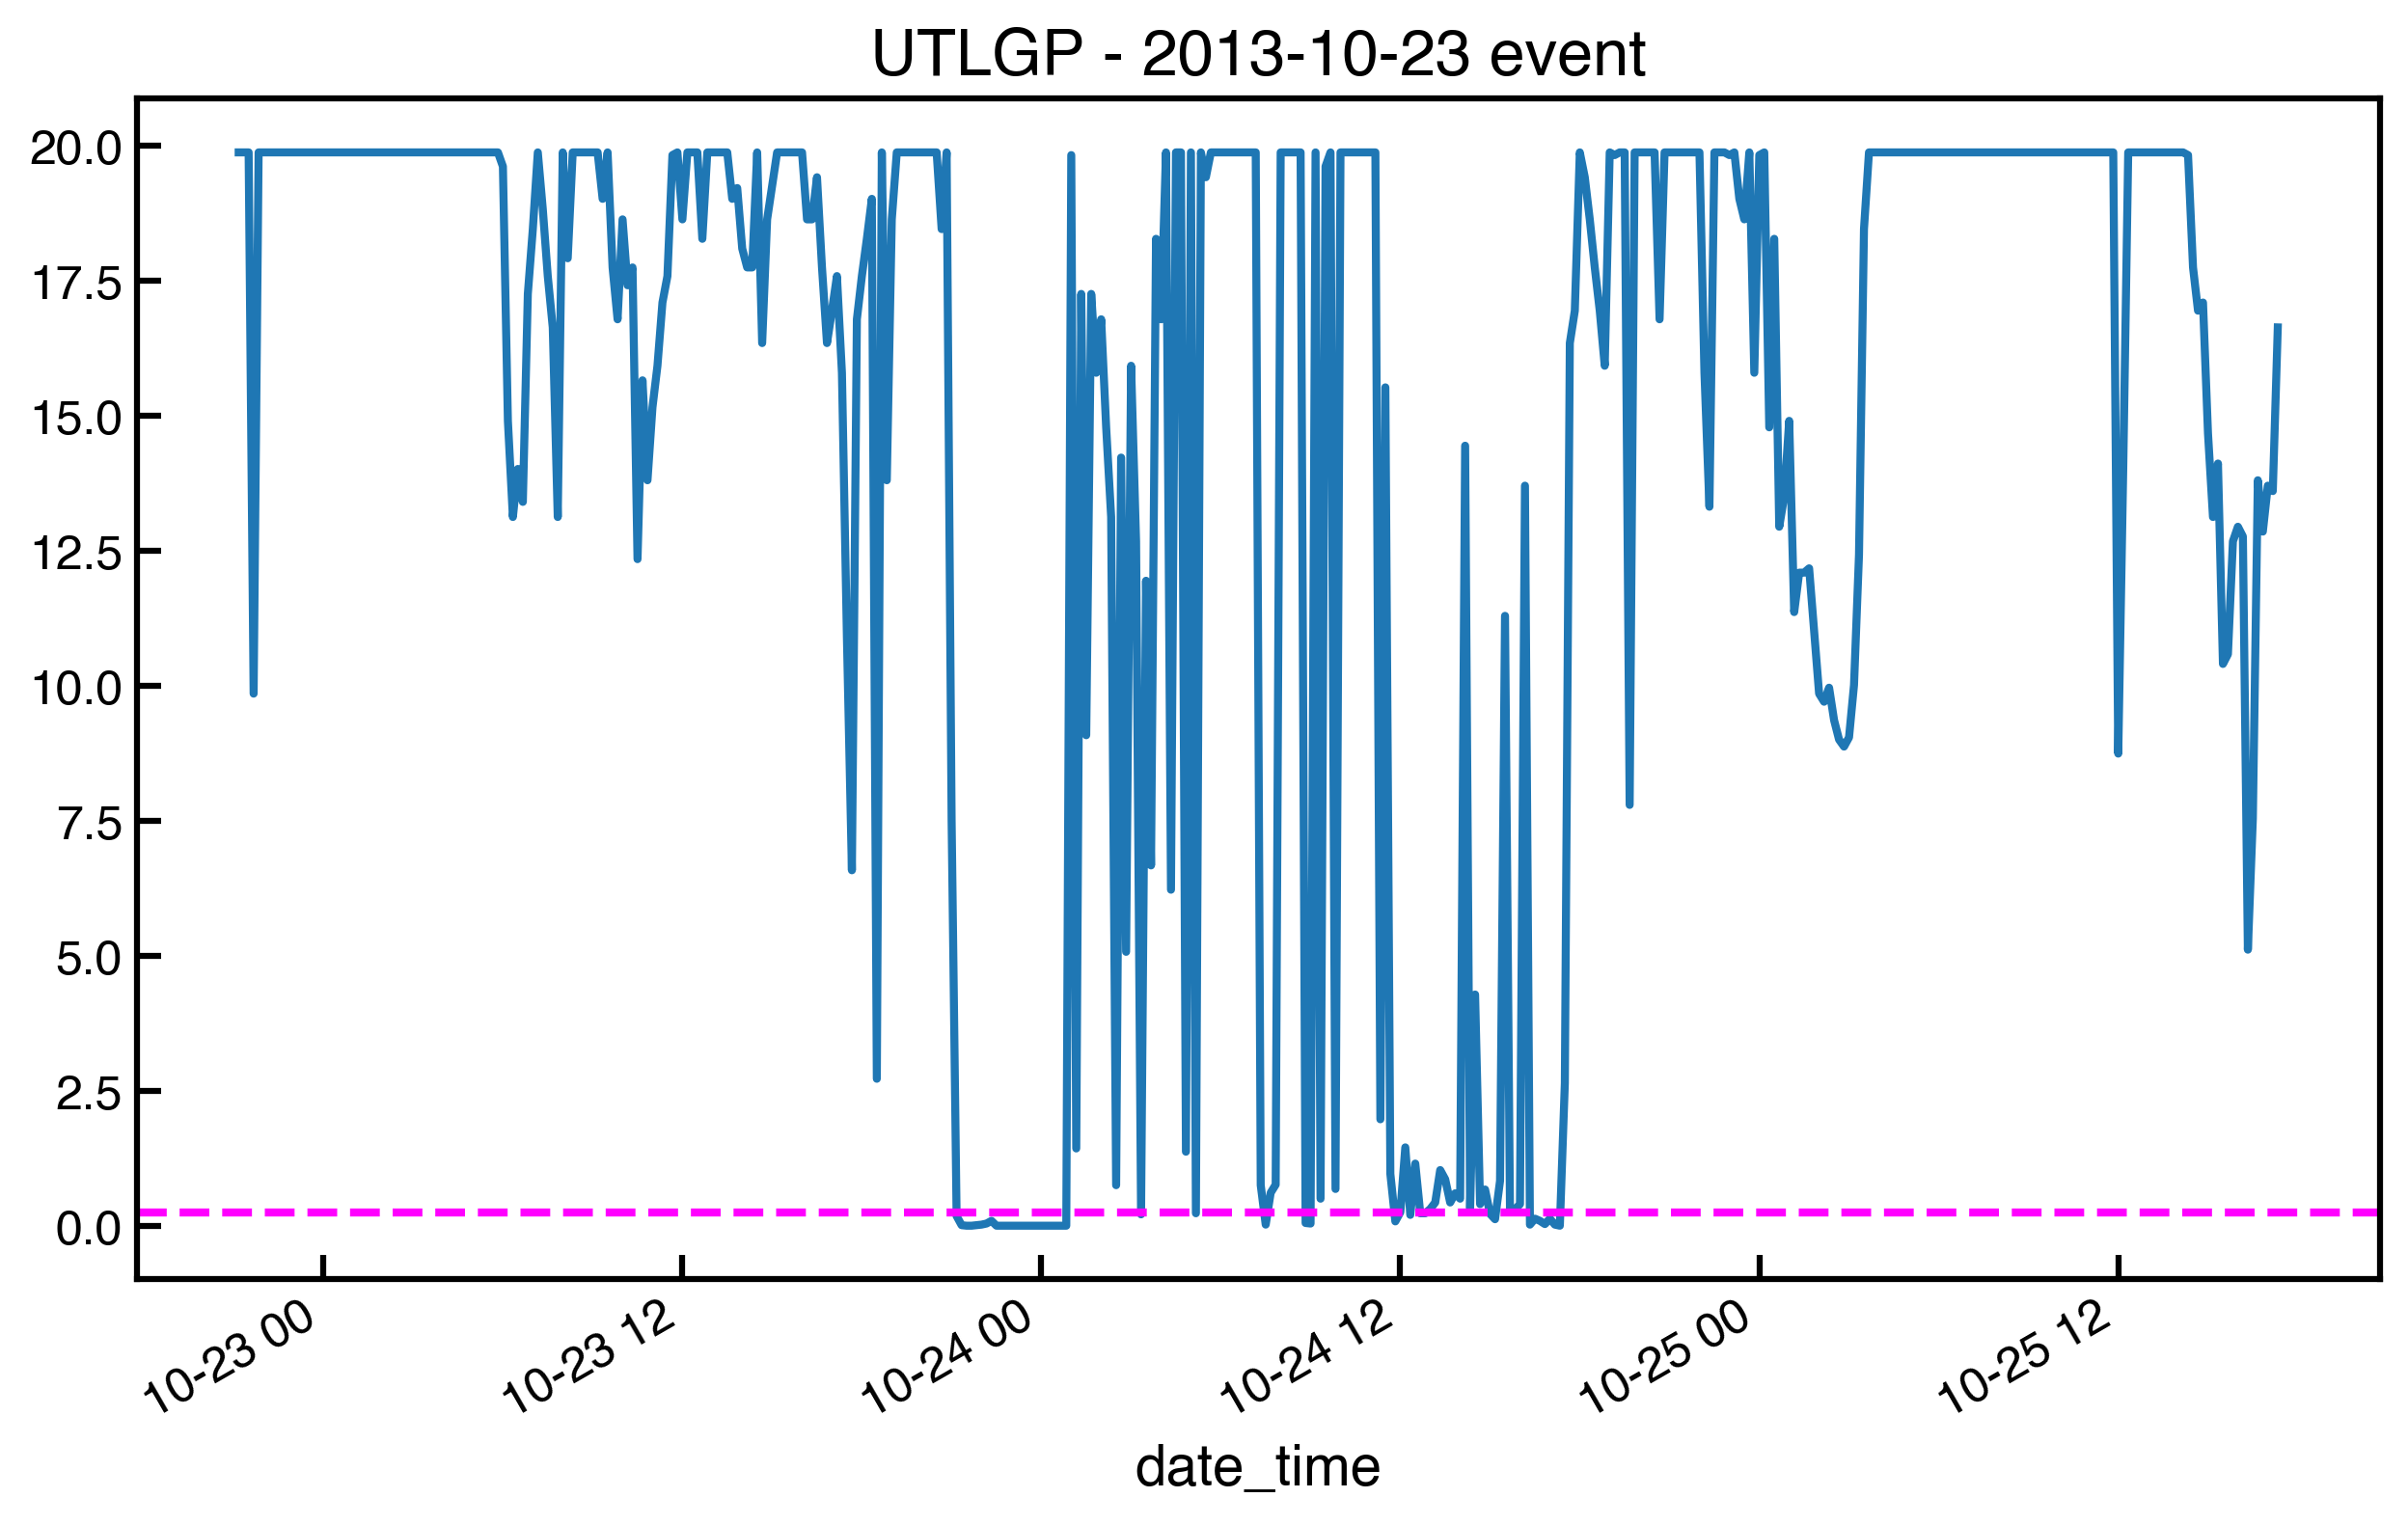

In [9]:
# Find first location of dust event and plot the visibility time series 24 hours before and after
case_num = 1

# Convert the 'Start Date' and 'End Date' strings from the events_df DataFrame to pandas datetime objects
start_date = pd.to_datetime(events_df['Start Date'].loc[case_num]) - pd.Timedelta(hours=24)
end_date = pd.to_datetime(events_df['End Date'].loc[case_num]) + pd.Timedelta(hours=24)

# Get the time series data for the plot
stid_df_plot = get_stid_timeseries(stid, start_date, end_date, vrbls)

# Plot the visibility time series
# First, create title first

row_date = events_df['Start Date'].loc[case_num]

title = f"{stid} - {row_date.split(' ')[0]} event"
stid_df_plot['visibility'].plot(title=title)

# For "dust event" time series, plot vertical bar if true 
# for ix, row in stid_df_plot.iterrows():
#     if row['dust_event']:
#         plt.axvline(ix, color='red', linestyle='--', alpha=0.5)



plt.axhline(viz_miles, color='magenta', linestyle='--', label='Dust threshold')
plt.show()


In [10]:
# Now count how many times there is an exceedence of the dust threshold for each site (below viz_miles, e.g., 0.5 miles)
# We avoid multiple counting of one event independently
# Cluster exceedence events that must be separated by a gap of 24 hours (else only count the first)

# Go in time order, and an event starts when

In [11]:
# Task 2 - 24-hour meteograms of visibility 
# Do similarly but for different settings of start and end time (24 hours), and location.

# First, let's set the stid to use for visualisation per location 
stids_vis = {'H3': 'UTJUN', 'EQ': 'UT215', 'MG': 'UTMV2', 'He': 'UTJUN', 'O2': 'KOGD'}

# Let's create a dataframe that mirrors the Markdown table above
# The index is case label, and the two columns are site and date (local) 
# These dates are in US format so we convert them later!
data = {'Site': ['H3', 'H3', 'H3', 'H3', 'EQ', 'EQ', 'EQ', 'EQ', 'EQ', 'H3', 'MG', 'MG', 'He', 'He', 'O2', 'O2'],
        'Date': ['04/23/2022', '05/31/2022', '06/17/2022', '06/20/2022', '06/17/2022', '06/18/2022', '06/20/2022', '09/07/2020', '09/09/2020', '12/20/2017', '12/20/2017', '12/21/2017', '04/14/2015', '04/15/2015', '04/14/2015', '04/15/2015']}

# Convert string dates to datetime objects
data['Date'] = [datetime.datetime.strptime(date, "%m/%d/%Y") for date in data['Date']]

# Make the indices the case label (starting at 1)
case_df = pd.DataFrame(data, index=range(1, len(data['Site'])+1))
case_df

,Site,Date
1,H3,2022-04-23
2,H3,2022-05-31
3,H3,2022-06-17
4,H3,2022-06-20
5,EQ,2022-06-17
6,EQ,2022-06-18
7,EQ,2022-06-20
8,EQ,2020-09-07
9,EQ,2020-09-09
10,H3,2017-12-20



 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202204221700&end=202204231659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202205301700&end=202205311659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202206161700&end=202206171659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202206191700&end=202206201659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UT215&start=202206161700&end=202206171659&vars=wind_di

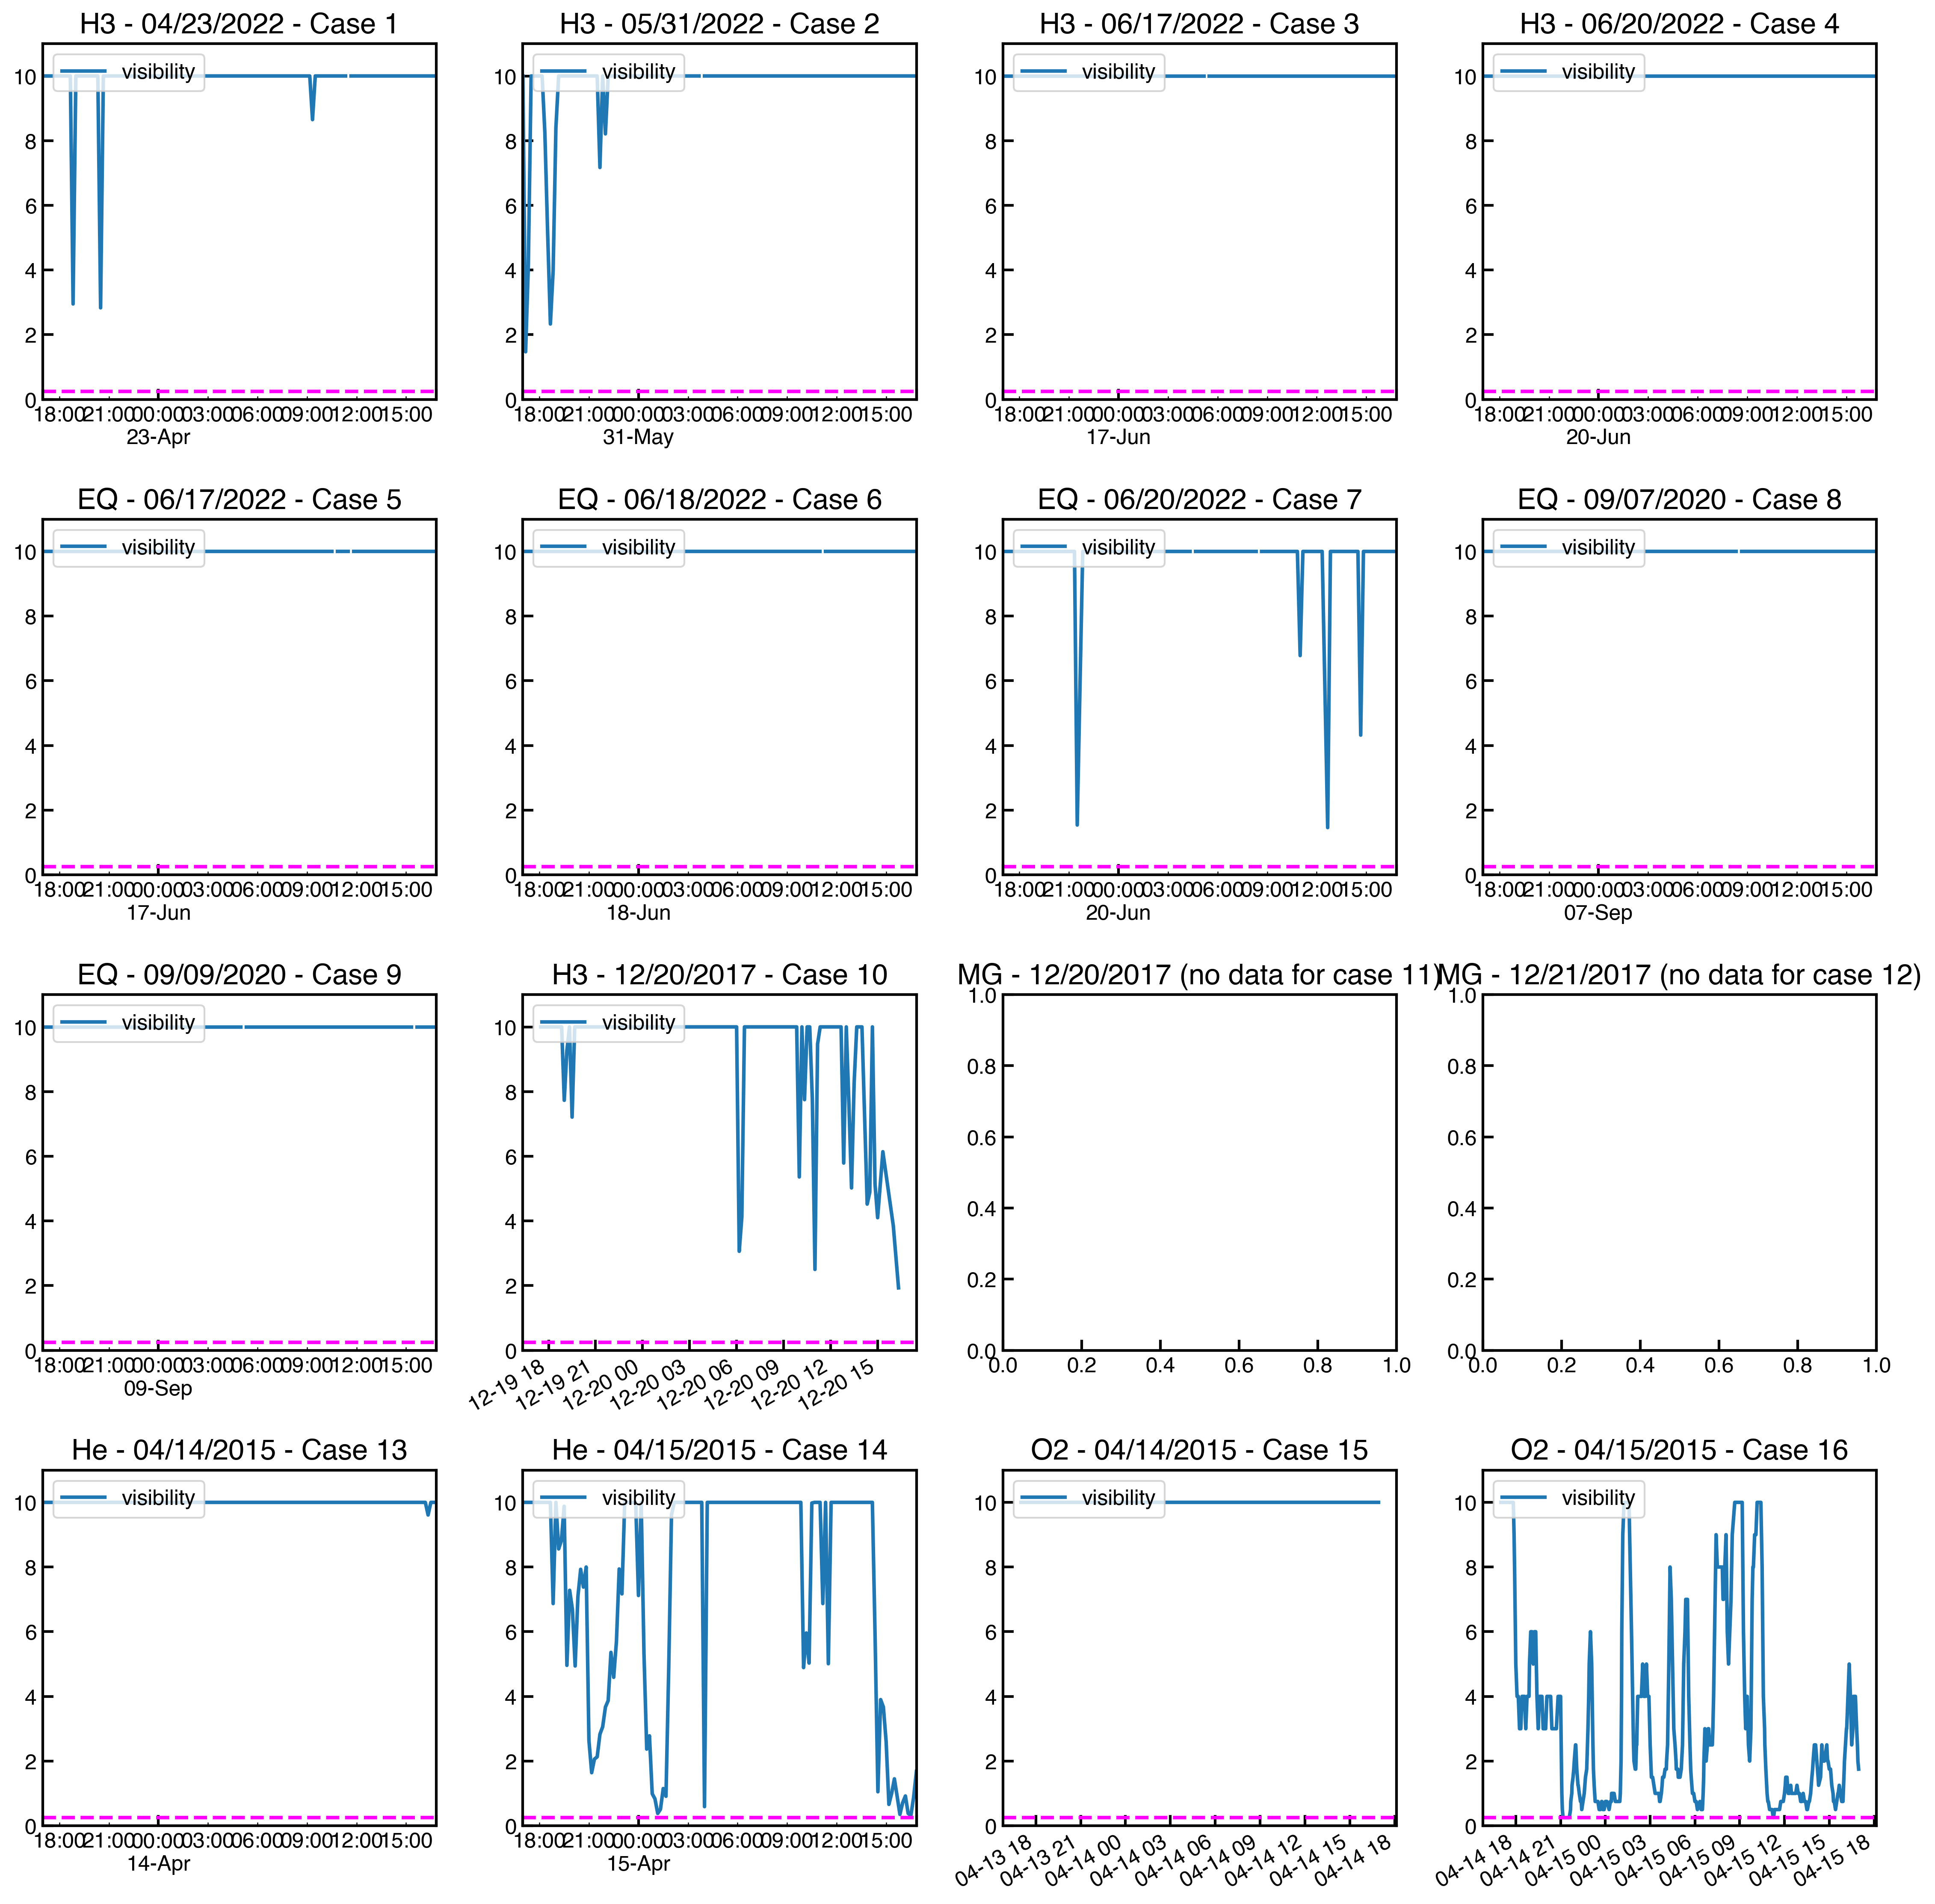

In [12]:
# Set the variables to download
# vrbls = ["visibility",]
# Also get wind direction for wind rose

vrbls = ['wind_direction', 'wind_speed', 'visibility']

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
axes = axes.flatten()  # flatten the 2D array to 1D for easier indexing

# Loop through the dataframe
for cx, row in case_df.iterrows():
    # cx is the case number, starting at 1
    ix = cx - 1  # index for the subplot, starting at 0
    stid = stids_vis[row['Site']]
    start_date = datetime.datetime(row['Date'].year, row['Date'].month, row['Date'].day, 0, 0, 0
                                   ) - datetime.timedelta(hours=7) # UTC to local
    end_date = datetime.datetime(row['Date'].year, row['Date'].month, row['Date'].day, 23, 59, 59
                                 ) - datetime.timedelta(hours=7) # UTC to local
    
    # For title, set format of date as MM/DD/YYYY
    row_date = row['Date'].strftime("%m/%d/%Y")
    
    try:
        stid_df = get_stid_timeseries(stid, start_date, end_date, vrbls)
    except:
        print("No data for this time.")
        axes[ix].set_title(f"{row['Site']} - {row_date} (no data for case {cx})")
        continue
    
    # Plot on the current subplot
    ax = axes[ix]
    
    title = f"{row['Site']} - {row_date} - Case {cx}"
    stid_df.plot(y='visibility', title=title, ax=ax)
    ax.set_xlabel('')  # remove x-label for clarity
    
    ax.set_ylim(0, 11)  # set y-axis limits for visibility in miles
    
    
    # legend in each subplot in top left 
    ax.legend(loc='upper left')
    
    # Plot wind rose for this day, using the column "wind_dir" and "wind_speed"
    
    # Horizontal magenta line at "viz_miles" miles (e.g. 0.5) for dust threshold
    ax.axhline(viz_miles, color='magenta', linestyle='--', label='Dust threshold')

# Remove unused subplots
# for i in range(ix+1, 16):
#     fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UT215&start=202206191700&end=202206201659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN



/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_85396/2354181613.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


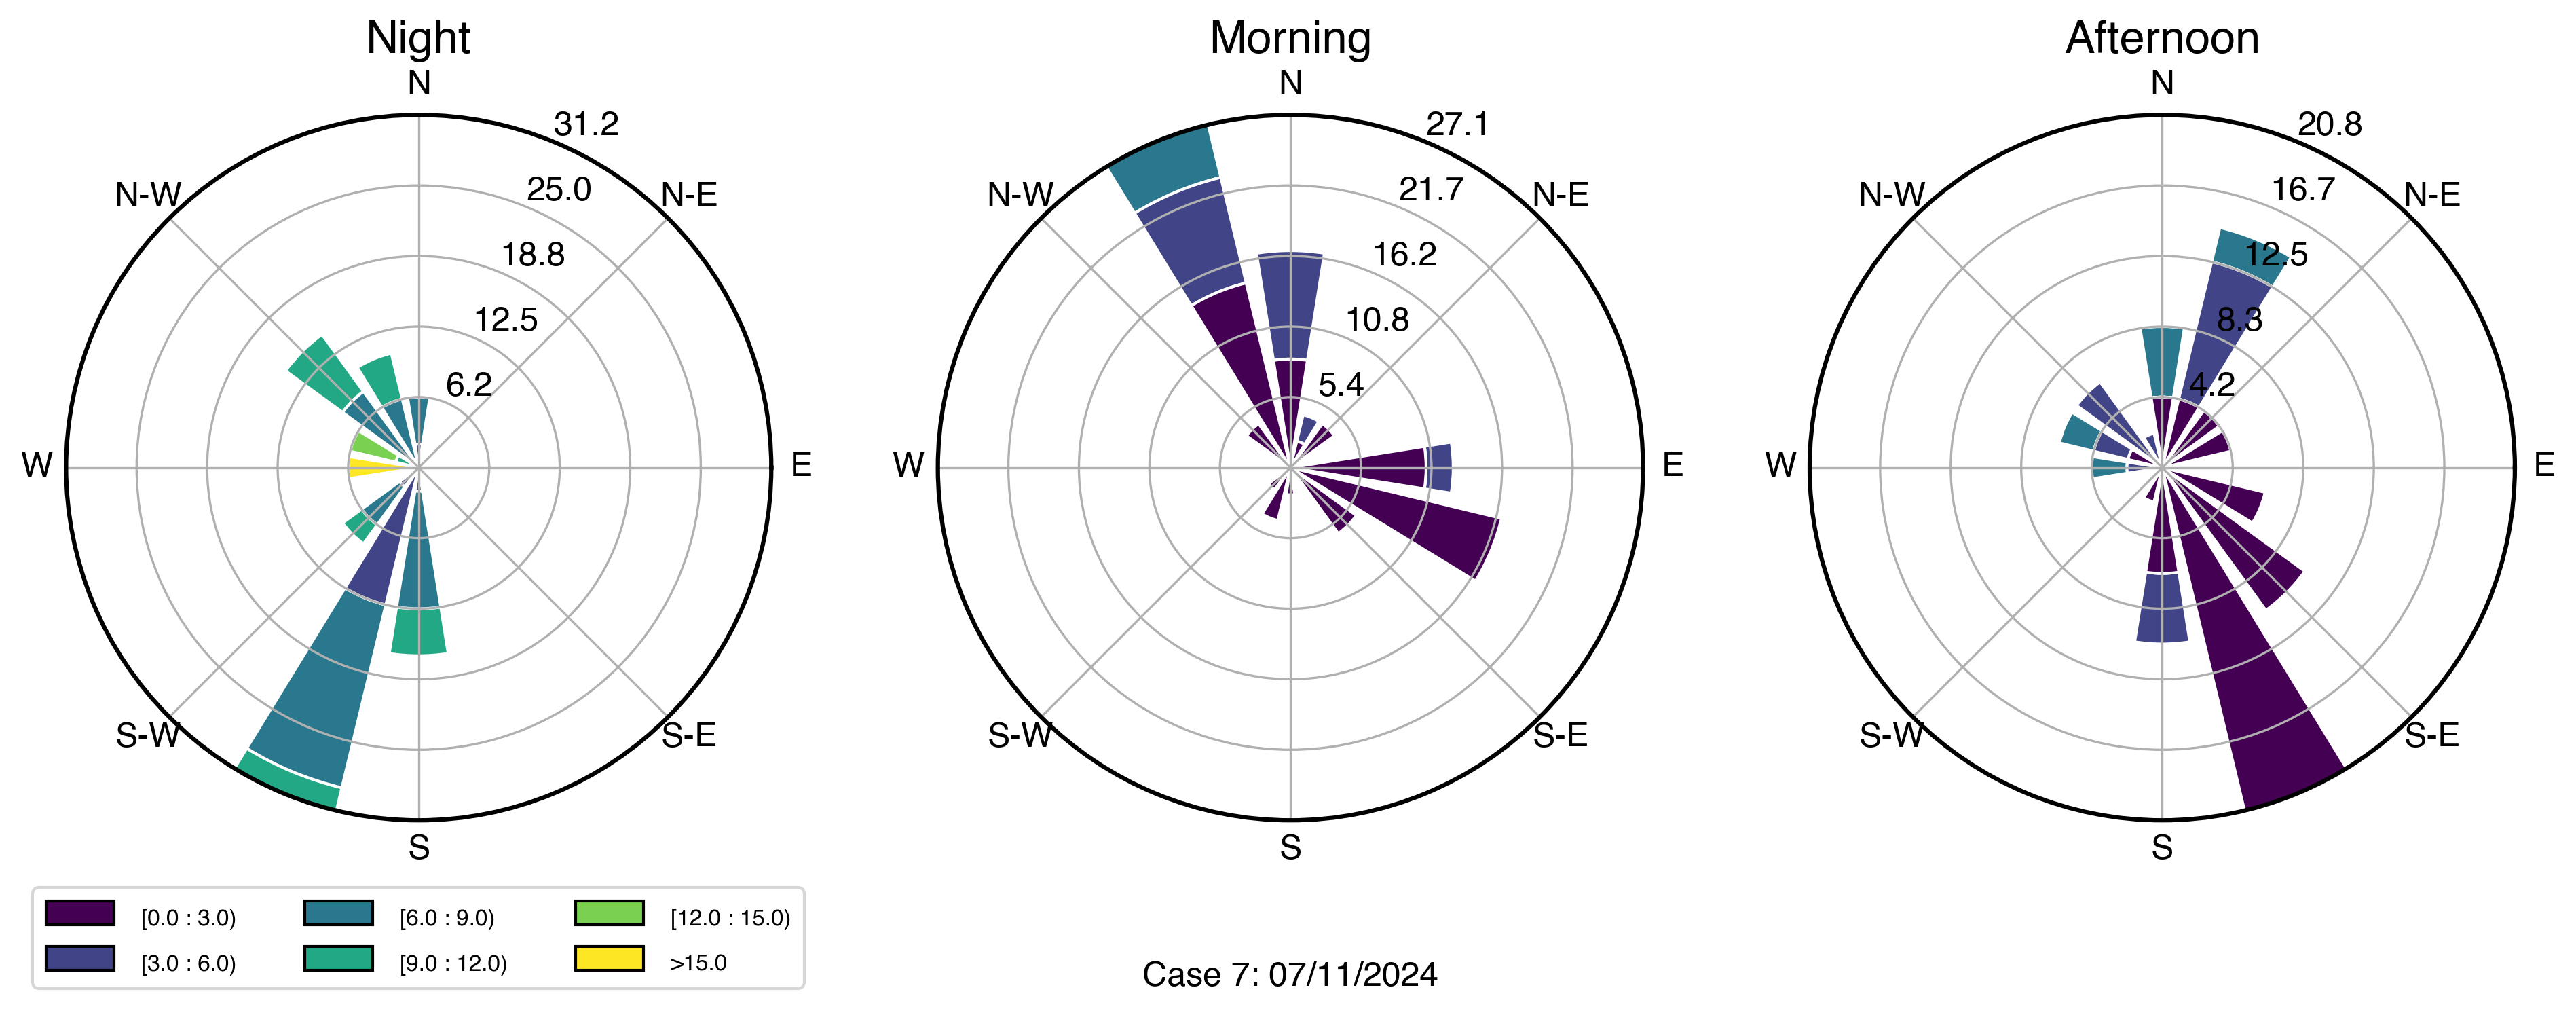

In [13]:
# plot wind_direction wind-rose with stid_df data and the windrose package 

# pick a few events to study

fig,ax = plot_case_windroses(7, title=True, case_df=case_df)
fig.show()

In [14]:
# Loop over all cases and save each figure to a file in the folder "figures"
if not os.path.exists("figures"):
    os.makedirs("figures")
    
for cx, row in case_df.iterrows():
    try:
        fig, ax = plot_case_windroses(cx, case_df=case_df)
    except:
        print(f"No data for case {cx}")
        continue
    fig.savefig(f"figures/case_{cx}.png")
    plt.close(fig)


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202204221700&end=202204231659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202205301700&end=202205311659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202206161700&end=202206171659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UTJUN&start=202206191700&end=202206201659&vars=wind_direction,wind_speed,visibility&token=🙈HIDDEN


 🚚💨 Speedy Delivery from Synoptic API [timeseries]: https://api.synopticdata.com/v2/stations/timeseries?stid=UT215&start=202206161700&end=202206171659&vars=wind_di

In [15]:
# Download synoptic charts to folder "charts" for each case
# The maps are available online 
# Template for URL follows https://www.wpc.ncep.noaa.gov/dailywxmap/htmlimages/sfcplot_sm_20240710.gif
# The date is in format YYYYMMDD
# The folder is "charts" and the file is "synoptic_case_{cx}.gif"

if not os.path.exists("charts"):
    os.makedirs("charts")
    
for cx, row in case_df.iterrows():
    date_str = row['Date'].strftime("%Y%m%d")
    url = f"https://www.wpc.ncep.noaa.gov/dailywxmap/htmlimages/sfcplot_sm_{date_str}.gif"
    
    # Use requests to fetch the image
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Write the image content to a file
        with open(f"charts/synoptic_case_{cx}.gif", 'wb') as file:
            file.write(response.content)
    else:
        print(f"Failed to download image for case {cx}")